In this notebook, we will do the Exploratory data analysis of our project after the dataset that we have filtered.
An important note is that the dataset comes from the LINCS data that is itself very clean. As a reminder the values that we have for the genes IDs are the difference of the genes expression before and after a certain treatment that is names under pertu_iname. These values have been normalized using the z-score

Load dataset

In [ ]:
import pandas as pd
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
path_to_file = '/content/drive/MyDrive/filtered_final_dataset.parquet'
genes_expression = pd.read_parquet(path_to_file)
genes_expression.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_idose,pert_itime,distil_id,embedding,780,...,6915,6253,7264,5467,2767,23038,57048,79716,pert_itime_value,pert_itime_unit
0,LJP005_A375_24H:A03,DMSO,DMSO,ctl_vehicle,A375,None,24 h,LJP005_A375_24H_X1_B19:A03|LJP005_A375_24H_X2_...,"[0.5616036, -0.13782915, 0.2569403, 0.05337388...",-0.154526,...,-0.074198,0.366143,0.323543,0.198538,-0.075226,-1.076814,-0.240803,0.105998,24,h
1,LJP005_A375_24H:A04,DMSO,DMSO,ctl_vehicle,A375,None,24 h,LJP005_A375_24H_X1_B19:A04|LJP005_A375_24H_X2_...,"[0.5616036, -0.13782915, 0.2569403, 0.05337388...",0.113874,...,0.138172,0.520369,0.197536,-0.177739,0.063853,-0.904253,0.040530,-0.619656,24,h
2,LJP005_A375_24H:A05,DMSO,DMSO,ctl_vehicle,A375,None,24 h,LJP005_A375_24H_X1_B19:A05|LJP005_A375_24H_X2_...,"[0.5616036, -0.13782915, 0.2569403, 0.05337388...",-0.038252,...,0.429882,0.008059,-0.216541,0.887142,0.156324,-0.939757,-0.093534,-0.260954,24,h
3,LJP005_A375_24H:A06,DMSO,DMSO,ctl_vehicle,A375,None,24 h,LJP005_A375_24H_X1_B19:A06|LJP005_A375_24H_X2_...,"[0.5616036, -0.13782915, 0.2569403, 0.05337388...",0.466993,...,0.920847,0.427959,-0.354371,0.903572,0.505928,-0.468805,1.793977,-0.642835,24,h
4,LJP005_A375_24H:A07,BRD-K76908866,CP-724714,trt_cp,A375,10.0 um,24 h,LJP005_A375_24H_X1_B19:A07|LJP005_A375_24H_X2_...,"[0.29808575, 0.10792902, -0.66687685, 0.768152...",-1.462477,...,0.509720,0.385096,-6.896286,0.728512,-0.183455,0.852644,1.406259,-0.416583,24,h


#1 Checking missing values

In [ ]:
genes_expression.isna().sum().sum()

np.int64(7215)


There are no missing values, the dataset, the discrepancies arise because I had previously run this notebook and applied modifications to the cleaned dataset; however, I've left the explanations of those actions in the subsequent cells.

# The pert_idose column contains negative values (-666), which is unexpected. It appears the dataset creator set -666 as a NaN value for pert_idose. We will also check for similar values in the pert_itime column.

In [ ]:
idose= genes_expression[genes_expression['pert_idose']=='-666']
itime = genes_expression[genes_expression['pert_itime']=='-666']
print(idose.shape)
print(itime.shape)

(0, 989)
(0, 989)


# In order to use pert_idose and pert_itime as features for our upcoming models without reducing the size of our dataset we will replace the -666 values by np.nan. We will also build two columns from the pert_itime one, pert_itime_value containing the numerical value for example 24 if it was 24h in pert_itime and pert_itime_unit containing the h if the pert_itime was expressed in hours.

In [ ]:
import numpy as np

genes_expression['pert_idose'] = genes_expression['pert_idose'].replace('-666', np.nan)

genes_expression['pert_itime'] = genes_expression['pert_itime'].replace('-666', np.nan)


extraction_itime = genes_expression['pert_itime'].astype(str).str.extract(r'([\d\.]*)\s*(.*)')
genes_expression['pert_itime_value'] = pd.to_numeric(extraction_itime[0], errors='coerce')
genes_expression['pert_itime_unit'] = extraction_itime[1].replace('', np.nan)

extraction_idose = genes_expression['pert_idose'].astype(str).str.extract(r'([\d\.]*)\s*(.*)')
genes_expression['pert_idose_value'] = pd.to_numeric(extraction_idose[0], errors='coerce')
genes_expression['pert_idose_unit'] = extraction_idose[1].replace('', np.nan)

genes_expression

,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_idose,pert_itime,distil_id,embedding,780,...,7264,5467,2767,23038,57048,79716,pert_itime_value,pert_itime_unit,pert_idose_value,pert_idose_unit
0,LJP005_A375_24H:A03,DMSO,DMSO,ctl_vehicle,A375,None,24 h,LJP005_A375_24H_X1_B19:A03|LJP005_A375_24H_X2_...,"[0.5616036, -0.13782915, 0.2569403, 0.05337388...",-0.154526,...,0.323543,0.198538,-0.075226,-1.076814,-0.240803,0.105998,24,h,NaN,None
1,LJP005_A375_24H:A04,DMSO,DMSO,ctl_vehicle,A375,None,24 h,LJP005_A375_24H_X1_B19:A04|LJP005_A375_24H_X2_...,"[0.5616036, -0.13782915, 0.2569403, 0.05337388...",0.113874,...,0.197536,-0.177739,0.063853,-0.904253,0.040530,-0.619656,24,h,NaN,None
2,LJP005_A375_24H:A05,DMSO,DMSO,ctl_vehicle,A375,None,24 h,LJP005_A375_24H_X1_B19:A05|LJP005_A375_24H_X2_...,"[0.5616036, -0.13782915, 0.2569403, 0.05337388...",-0.038252,...,-0.216541,0.887142,0.156324,-0.939757,-0.093534,-0.260954,24,h,NaN,None
3,LJP005_A375_24H:A06,DMSO,DMSO,ctl_vehicle,A375,None,24 h,LJP005_A375_24H_X1_B19:A06|LJP005_A375_24H_X2_...,"[0.5616036, -0.13782915, 0.2569403, 0.05337388...",0.466993,...,-0.354371,0.903572,0.505928,-0.468805,1.793977,-0.642835,24,h,NaN,None
4,LJP005_A375_24H:A07,BRD-K76908866,CP-724714,trt_cp,A375,10.0 um,24 h,LJP005_A375_24H_X1_B19:A07|LJP005_A375_24H_X2_...,"[0.29808575, 0.10792902, -0.66687685, 0.768152...",-1.462477,...,-6.896286,0.728512,-0.183455,0.852644,1.406259,-0.416583,24,h,10.0,um
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111324,XPR002_YAPC.311_96H:P20,BRDN0000585533,LUCIFERASE,ctl_vector,YAPC.311,None,96 h,XPR002_YAPC.311_96H_X1_B22:P20|XPR002_YAPC.311...,"[0.23478751, -0.013486914, -0.52614844, 0.5713...",1.586212,...,-0.305129,-0.459347,0.157676,-0.545996,-0.609382,-1.913664,96,h,NaN,None
111325,XPR002_YAPC.311_96H:B24,BRDN0000732954,JUN,trt_xpr,YAPC.311,None,96 h,XPR002_YAPC.311_96H_X2_B22:B24|XPR002_YAPC.311...,"[0.07169882, 0.5021437, -0.64423954, 0.3837782...",-0.787950,...,0.508450,-1.390200,-0.788450,-0.567850,-0.879150,-2.104900,96,h,NaN,None
111326,XPR002_YAPC.311_96H:G23,BRDN0001055014,EGFR,trt_xpr,YAPC.311,None,96 h,XPR002_YAPC.311_96H_X2_B22:G23|XPR002_YAPC.311...,"[0.29187647, 0.16660748, -0.56586105, 0.817252...",-0.369600,...,-0.172900,-0.266000,0.483900,0.780400,0.544000,-2.465550,96,h,NaN,None
111327,XPR002_YAPC.311_96H:J16,BRDN0000585515,LUCIFERASE,ctl_vector,YAPC.311,None,96 h,XPR002_YAPC.311_96H_X2_B22:J16|XPR002_YAPC.311...,"[0.23478751, -0.013486914, -0.52614844, 0.5713...",-1.218550,...,-0.108250,-0.291000,-0.248200,-0.154700,-0.022150,-0.006600,96,h,NaN,None


# 2 We will perform outlier detection by plotting the Principal Components 1 (PC1) and 2 (PC2) and visually inspecting the Principal Component Analysis (PCA) results

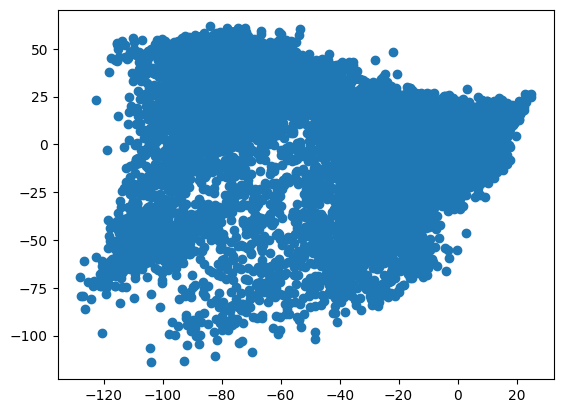

In [ ]:
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

outlier = genes_expression.drop(columns=['sig_id','pert_id','pert_iname','pert_type','cell_id','pert_idose','pert_itime','distil_id','embedding','pert_itime_value','pert_itime_unit','pert_idose_value','pert_idose_unit'])

pca = PCA(n_components=2)
coords = pca.fit_transform(outlier)

plt.scatter(coords[:,0], coords[:,1])

We conclude based on the PCA representation that we do not observe samples behaving as outliers.There is one main cluster and all the values are at a reasonable distance from it in the first two components.

# 3 Distribution analysis. We will examine the global distribution of gene expression differences (before vs. after treatment) across all genes. Then, we will display the absolute change to assess the effect of a certain drug.

Text(0, 0.5, 'Occurence')

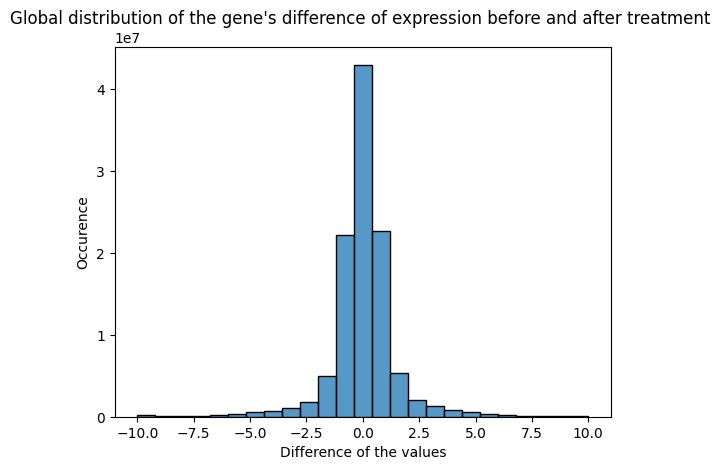

In [ ]:
import seaborn as sns
distribution = outlier
sns.histplot(distribution.to_numpy().flatten(),bins = 25)
plt.title("Global distribution of the gene's difference of expression before and after treatment ")
plt.xlabel("Difference of the values")
plt.ylabel("Occurence")

This is the representation of the global distribution (across all genes and all treatments) of the dataset, it follows a narrow centered at zero Gaussian distribution.

We interpret this as :  

-- The majority of the genes remain stable after the treatment.

-- Balanced up and down regulation.

-- No systemic bias.

-- The dataset shows no batch artifacts or toxic global effects.


# 4 Change specific plot

Here, we plotted a heatmap of the values to potentially identify trends in gene expression change. I applied a convolution because the original function was otherwise too computationally intensive to run on a Colab instance using an NVIDIA A100 GPU

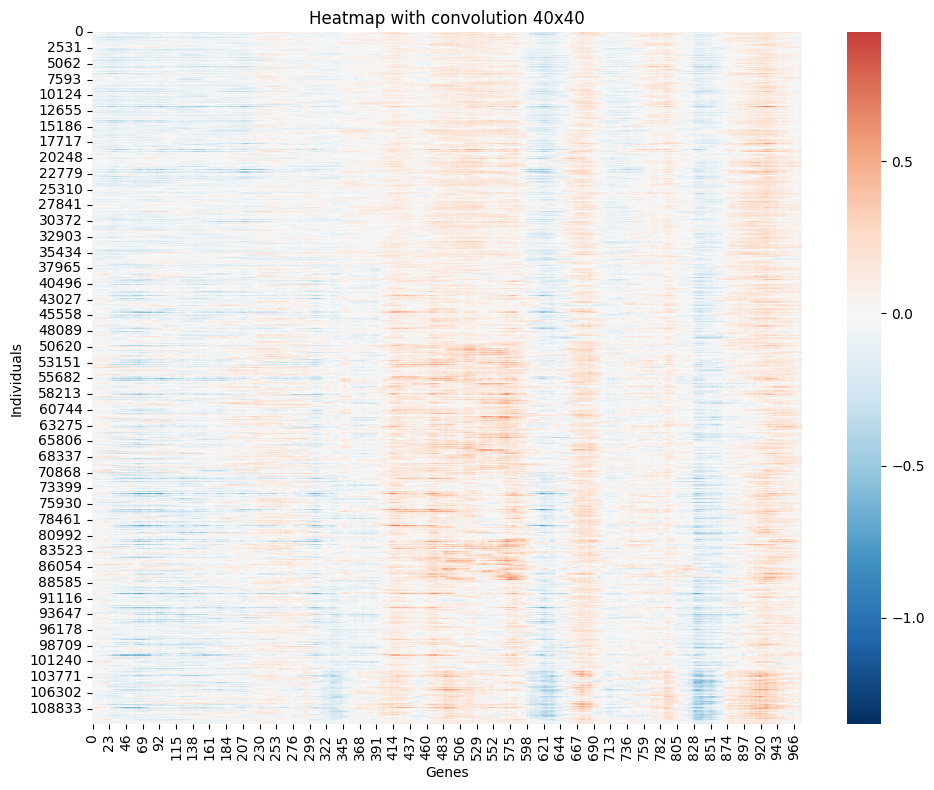

In [ ]:

from scipy.signal import convolve2d
def heatmap(df):

  mat = df.values

  kernel_size = 40
  kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)

  smoothed = convolve2d(mat, kernel, mode='same')

  plt.figure(figsize=(10, 8))
  sns.heatmap(smoothed, cmap="RdBu_r", center=0)
  plt.title(f"Heatmap with convolution {kernel_size}x{kernel_size}")
  plt.xlabel("Genes")
  plt.ylabel("Individuals")
  plt.tight_layout()
  plt.show()
heatmap(outlier)

Most genes exhibit a consistent regulatory response (either up- or down-regulation) when subjected to various perturbations. The simultaneous occurrence of strong positive and negative responses within a single gene is rare.Furthermore, there are few distinct clusters among the samples/individuals. We attribute this primarily to the wide variety of different treatments included in the dataset.

The following plot displays the variance for each gene, illustrating that some genes exhibit significantly higher variance than others. We chose to display the IDs of only ten genes; otherwise, the plot would have been unreadable.

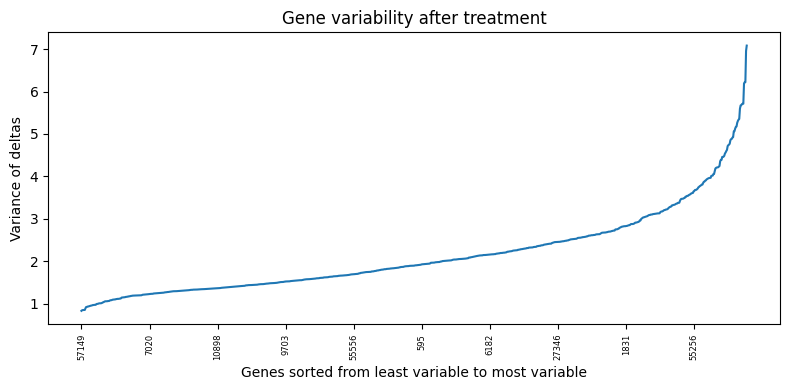

In [ ]:

def plot_variance_gene(df, step=100):
    var_sorted = df.var().sort_values()
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(var_sorted)), var_sorted.values)
    ticks = np.arange(0, len(var_sorted), step)
    plt.xticks(ticks, var_sorted.index[ticks], rotation=90, fontsize=6)

    plt.xlabel("Genes sorted from least variable to most variable")
    plt.ylabel("Variance of deltas")
    plt.title("Gene variability after treatment")
    plt.tight_layout()
    plt.show()

plot_variance_gene(outlier, step=100)


The following plot is a boxplot of the response averaged across the whole population. The goal of this visualization is to understand the magnitude of the population's response when exposed to any given treatment.

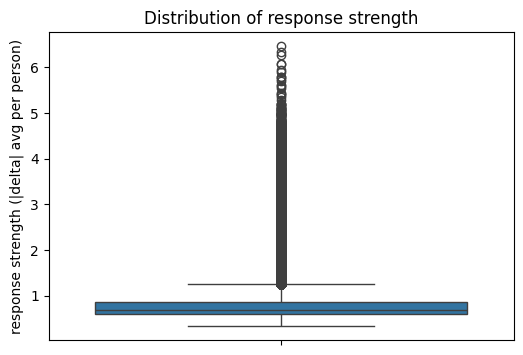

In [ ]:

def absolute_box_plot(df):
  scores = pd.DataFrame(index=df.index)
  scores["mean_abs_delta"]   = df.abs().mean(axis=1)
  scores["median_abs_delta"] = df.abs().median(axis=1)
  scores["max_abs_delta"]    = df.abs().max(axis=1)


  plt.figure(figsize=(6,4))
  sns.boxplot(y=scores["mean_abs_delta"])
  plt.ylabel("response strength (|delta| avg per person)")
  plt.title("Distribution of response strength")
  plt.show()
absolute_box_plot(outlier)


Most individuals have weak to moderate treatment responses, with average absolute deltas close to 0.8.
A minority of individuals show very large responses (deltas above 2–6), producing a long right tail.
This indicates that response strength is highly heterogeneous across treatments: most perturbations induce modest changes, but a subset produces very strong, widespread effects on gene expression.

In [ ]:
genes_expression.to_parquet('/content/drive/MyDrive/prediction_ready_final_dataset.parquet')